[1] -0.5  1.2

(Intercept)           x 
 -0.5626744   0.8956781

(Intercept)           x 
 -0.5037637   1.2590350

29.25033
214.87294


,mean,bias,rmse
MLE beta0,-0.564,-0.064,0.089
MLE beta1,0.740,-0.460,0.471
ROB beta0,-0.473,0.027,0.071
ROB beta1,1.294,0.094,0.170


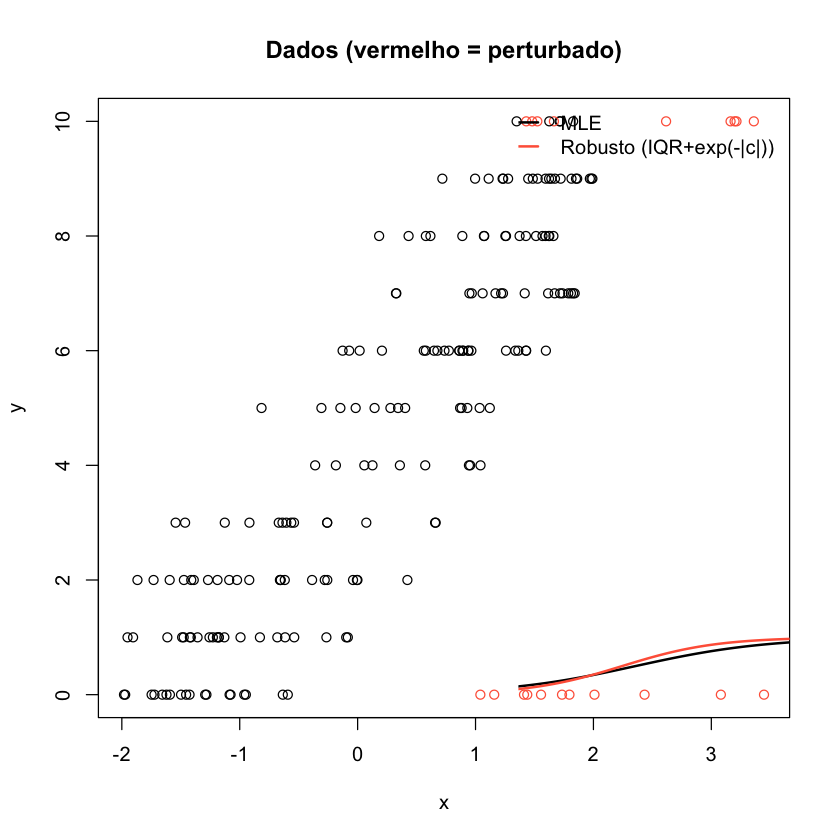

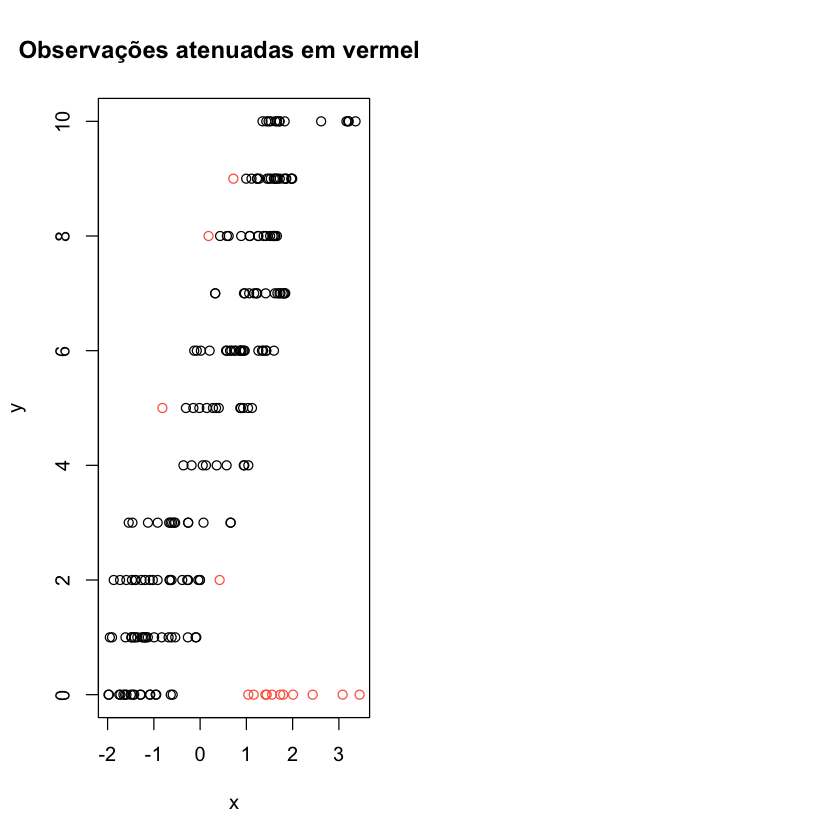

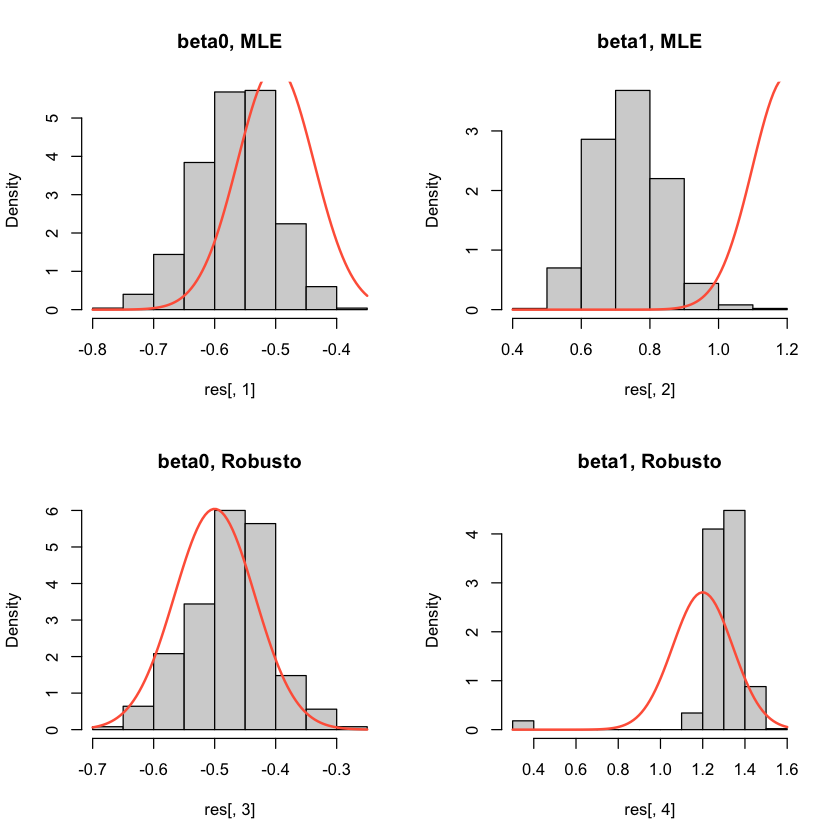

In [15]:
## ===========================
##  REGRESSÃO BINOMIAL ROBUSTA
## ===========================

expit = function(eta) 1/(1+exp(-eta))

set.seed(2025)

## ---------------------------
## Exemplo único (com ruído)
## ---------------------------
n = 200
m = rep(10, n)
x = runif(n, -2, 2)

alpha = -0.5
beta  =  1.2
theta = c(alpha, beta)

mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação (alavanca x e rótulos 0/m)
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

plot(y ~ x, col=ifelse(1:n %in% aux, "tomato", "black"), main="Dados (vermelho = perturbado)")

## MLE (referência)
fit0 = glm(cbind(y, m - y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## -------- método robusto (IQR + exp(-|c|)) --------
## p como na lousa
p = 1.5

## Equações de estimação empilhadas
L = function(theta){
  eta = theta[1] + theta[2]*x
  mu  = expit(eta)
  r   = (y - m*mu)                         # resíduo "cru" estilo Poisson da aula
  cut = p * IQR(r)
  c_p = ifelse(abs(r) > cut, exp(-abs(r)), 1)  # atenuação
  cbind( c_p*(y - m*mu),
         c_p* x*(y - m*mu) )
}

## Norma^2 das equações (para o optim), igual ao “LL” do prof
LL = function(theta){
  u = colSums(L(theta))
  sum(u^2)
}

## Sandwich no estilo da lousa (B e V)
B = function(theta){
  U = L(theta)
  t(U) %*% U / n
}
V = function(theta){
  eps = 1e-6
  U0  = colSums(L(theta))
  J   = matrix(NA_real_, 2, 2)
  for(j in 1:2){
    th = theta
    th[j] = th[j] + eps
    Uj = colSums(L(th))
    J[, j] = (Uj - U0)/eps
  }
  solve(J) %*% B(theta) %*% t(solve(J))
}

## inicializa em MLE e otimiza
fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

## padronização com autovetores (mesmo teatrinho V_0.5 e W1)
E = eigen(V.hat)
V_0.5 = E$vectors %*% diag(1/sqrt(E$values)) %*% t(E$vectors)
W1 = sqrt(n) * V_0.5 %*% (theta.hat1 - theta)

par(mfrow=c(1,2))
## curva MLE vs Robusta
xs = seq(min(x), max(x), length.out=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto (IQR+exp(-|c|))"), col=c("black","tomato"), lwd=2, bty="n")

## marca quem foi atenuado pelo corte atual em vermelho
eta.r = theta.hat1[1] + theta.hat1[2]*x
r.now = (y - m*expit(eta.r))
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Observações atenuadas em vermelho")

theta       ## verdadeiro
theta.hat0  ## MLE
theta.hat1  ## Robusto
W1          ## vetor padronizado

## ---------------------------
##   Monte Carlo
## ---------------------------
mc_binom_iqrexp = function(R=500, n=200, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)
    ## contamina igual ao exemplo
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

    ## MLE
    b_mle = coef(glm(cbind(y, m - y) ~ x, family=binomial()))

    ## robusto: mesmo L/LL com p-IQR e exp(-|c|)
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      exc = pmax(0, abs(r) - c)
      w   = exp(-exc)
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }

    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par, silent=TRUE)
    if(inherits(b_rob, "try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(99)
res = mc_binom_iqrexp(R=500, n=200, contam=0.15, p=1.5)

summ = function(v, tru) c(mean=mean(v, na.rm=TRUE),
                         bias=mean(v-tru, na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2, na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], theta[1]),
  "MLE beta1" = summ(res[,2], theta[2]),
  "ROB beta0" = summ(res[,3], theta[1]),
  "ROB beta1" = summ(res[,4], theta[2])
)
round(TAB, 3)

par(mfrow=c(2,2))
hist(res[,1], prob=TRUE, main="beta0, MLE");  curve(dnorm(x, mean(theta[1]), sd(res[,1],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,2], prob=TRUE, main="beta1, MLE");  curve(dnorm(x, mean(theta[2]), sd(res[,2],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,3], prob=TRUE, main="beta0, Robusto"); curve(dnorm(x, mean(theta[1]), sd(res[,3],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,4], prob=TRUE, main="beta1, Robusto"); curve(dnorm(x, mean(theta[2]), sd(res[,4],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)

[1] -0.5  1.2

(Intercept)           x 
 -0.5626744   0.8956781

(Intercept)           x 
 -0.4856487   1.2480537

78.65897
184.73299


,mean,bias,rmse
MLE beta0,-0.561,-0.061,0.087
MLE beta1,0.845,-0.355,0.370
ROB beta0,-0.484,0.016,0.068
ROB beta1,1.281,0.081,0.104


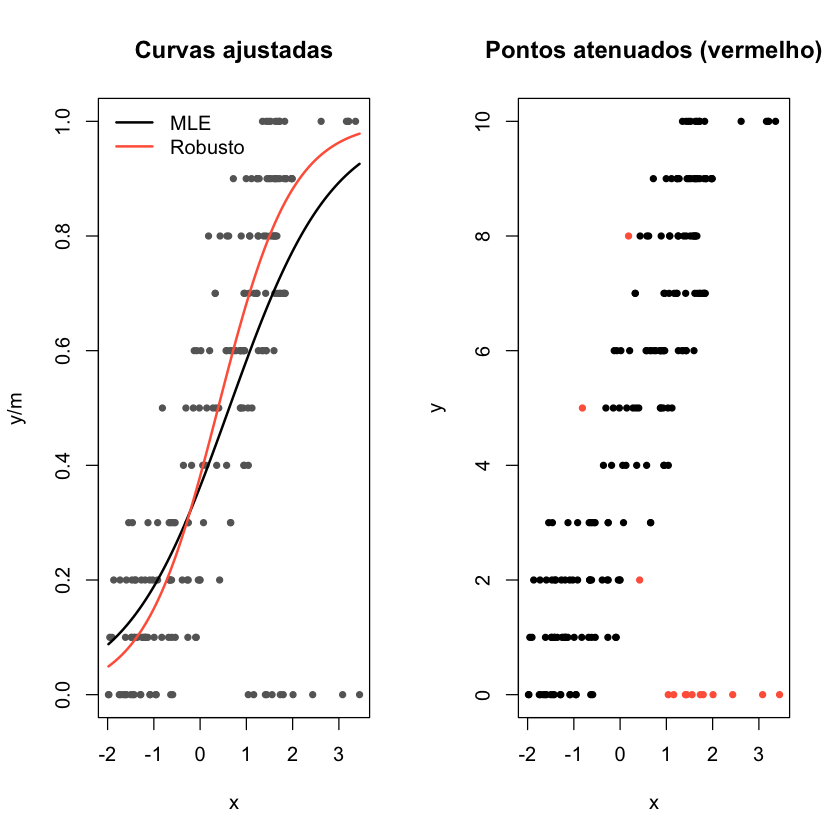

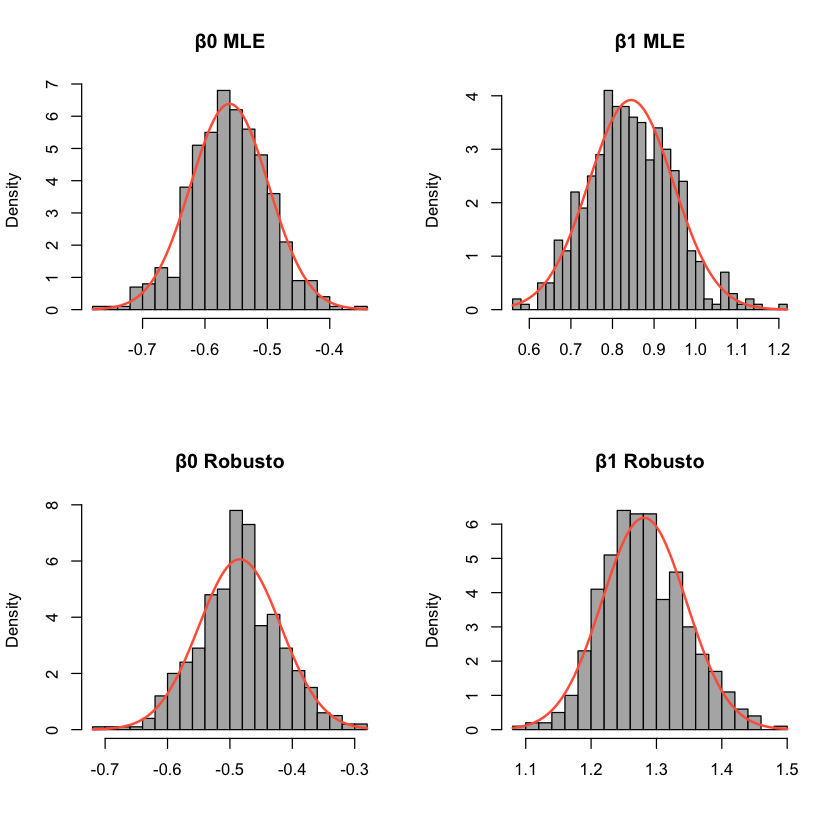

In [17]:
## ======================================
##  Regressão Binomial Robusta (IQR + exp(-(|r|-c)_+))
##  Estilo das aulas do prof.
## ======================================

expit = function(eta) 1/(1+exp(-eta))
set.seed(2025)

## -----------------------------
## Exemplo único
## -----------------------------
n = 200
m = rep(10, n)
x = runif(n, -2, 2)

theta = c(-0.5, 1.2)
mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação (mesmo padrão de sala)
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

## estimador clássico
fit0 = glm(cbind(y, m - y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## ---------------------------------
## Função de estimação robusta
## ---------------------------------
p = 1.5

L = function(th){
  eta = th[1] + th[2]*x
  mu  = expit(eta)
  r   = y - m*mu
  c   = p * IQR(r)
  exc = pmax(0, abs(r) - c)
  w   = exp(-exc)
  cbind( w*(y - m*mu),
         w*x*(y - m*mu) )
}

LL = function(th){
  u = colSums(L(th))
  sum(u^2)
}

B = function(th){
  U = L(th)
  t(U) %*% U / n
}

V = function(th){
  eps = 1e-6
  U0  = colSums(L(th))
  J   = matrix(NA_real_, 2, 2)
  for(j in 1:2){
    thj = th
    thj[j] = thj[j] + eps
    Uj = colSums(L(thj))
    J[, j] = (Uj - U0)/eps
  }
  solve(J) %*% B(th) %*% t(solve(J))
}

fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

E = eigen(V.hat)
V_0.5 = E$vectors %*% diag(1/sqrt(E$values)) %*% t(E$vectors)
W1 = sqrt(n) * V_0.5 %*% (theta.hat1 - theta)

## -----------------------------
## Visualização do exemplo
## -----------------------------
par(mfrow=c(1,2))
plot(y/m ~ x, pch=20, col="grey40", main="Curvas ajustadas")
xs = seq(min(x), max(x), length=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto"), col=c("black","tomato"), lwd=2, bty="n")

eta.r = theta.hat1[1] + theta.hat1[2]*x
r.now = y - m*expit(eta.r)
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Pontos atenuados (vermelho)", pch=20)

theta      # verdadeiro
theta.hat0 # MLE
theta.hat1 # Robusto
W1

## ======================================
## Simulação Monte Carlo 
## ======================================

mc_binom_iqrexp = function(R=500, n=200, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  theta = c(-0.5, 1.2)
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)

    ## contaminação
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

    ## MLE
    b_mle = coef(glm(cbind(y, m - y) ~ x, family=binomial()))

    ## robusto
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      exc = pmax(0, abs(r) - c)
      w   = exp(-exc)
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }
    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par,
                silent=TRUE)
    if(inherits(b_rob, "try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(99)
res = mc_binom_iqrexp(R=500, n=200, contam=0.10, p=1.5)

summ = function(v, tru) c(mean=mean(v,na.rm=TRUE),
                         bias=mean(v-tru,na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2,na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], -0.5),
  "MLE beta1" = summ(res[,2],  1.2),
  "ROB beta0" = summ(res[,3], -0.5),
  "ROB beta1" = summ(res[,4],  1.2)
)
round(TAB, 3)

## -----------------------------
## Plots dos resultados MC
## -----------------------------
## -----------------------------
## Plots dos resultados MC (com curva normal)
## -----------------------------
par(mfrow=c(2,2))

## β0 MLE
m0 = mean(res[,1], na.rm=TRUE)
s0 = sd(res[,1],   na.rm=TRUE)
hist(res[,1], prob=TRUE, breaks=25, col="grey70", main="β0 MLE", xlab="")
curve(dnorm(x, mean=m0, sd=s0), add=TRUE, col="tomato", lwd=2)
# abline(v=-0.5, col="black", lwd=2, lty=3)  # valor verdadeiro (opcional)

## β1 MLE
m1 = mean(res[,2], na.rm=TRUE)
s1 = sd(res[,2],   na.rm=TRUE)
hist(res[,2], prob=TRUE, breaks=25, col="grey70", main="β1 MLE", xlab="")
curve(dnorm(x, mean=m1, sd=s1), add=TRUE, col="tomato", lwd=2)
# abline(v=1.2, col="black", lwd=2, lty=3)

## β0 Robusto
mr0 = mean(res[,3], na.rm=TRUE)
sr0 = sd(res[,3],   na.rm=TRUE)
hist(res[,3], prob=TRUE, breaks=25, col="grey70", main="β0 Robusto", xlab="")
curve(dnorm(x, mean=mr0, sd=sr0), add=TRUE, col="tomato", lwd=2)
# abline(v=-0.5, col="black", lwd=2, lty=3)

## β1 Robusto
mr1 = mean(res[,4], na.rm=TRUE)
sr1 = sd(res[,4],   na.rm=TRUE)
hist(res[,4], prob=TRUE, breaks=25, col="grey70", main="β1 Robusto", xlab="")
curve(dnorm(x, mean=mr1, sd=sr1), add=TRUE, col="tomato", lwd=2)
# abline(v=1.2, col="black", lwd=2, lty=3)

[1] -0.5  1.2

(Intercept)           x 
 -0.5626744   0.8956781

(Intercept)           x 
 -0.4856487   1.2480537

78.65897
184.73299


,mean,bias,rmse
MLE beta0,-0.561,-0.061,0.087
MLE beta1,0.845,-0.355,0.370
ROB beta0,-0.484,0.016,0.068
ROB beta1,1.281,0.081,0.104


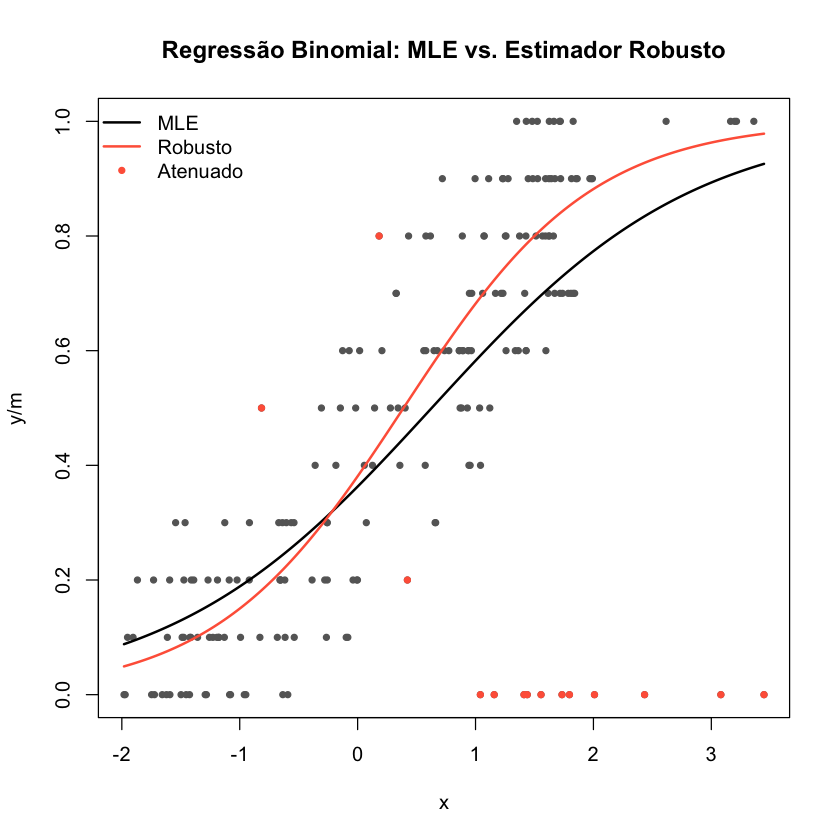

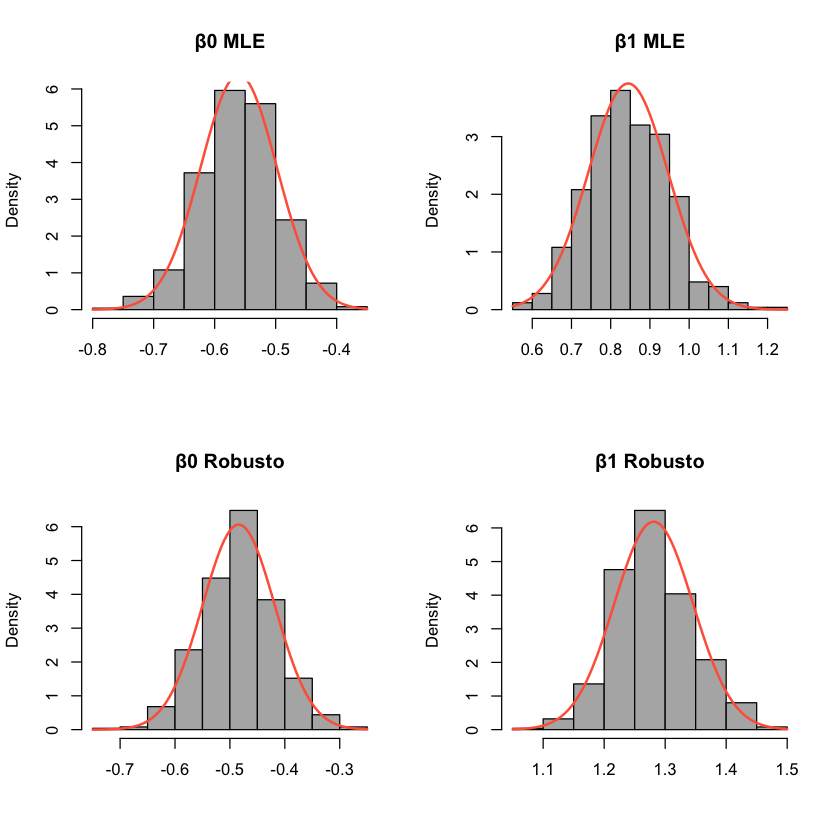

In [23]:
## ================================================
##  Regressão Binomial Robusta - {Prova}
## ================================================

expit = function(eta) 1/(1+exp(-eta))
set.seed(2025)

## ======================
## EXEMPLO ÚNICO
## ======================
n = 200
m = rep(10, n)
x = runif(n, -2, 2)

theta = c(-0.5, 1.2)              # valores verdadeiros
mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação (alavancagem + rótulos 0/m), como em sala
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

## MLE de referência
fit0 = glm(cbind(y, m-y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## ==== Estimador robusto: IQR + exp(-(|r|-c)_+) ====
p = 1.5

L = function(th){
  eta = th[1] + th[2]*x
  mu  = expit(eta)
  r   = y - m*mu
  c   = p * IQR(r)
  exc = pmax(0, abs(r) - c)
  w   = exp(-exc)
  cbind( w*(y - m*mu),
         w*x*(y - m*mu) )
}

LL = function(th){
  u = colSums(L(th))
  sum(u^2)
}

B = function(th){
  U = L(th)
  t(U) %*% U / n
}

V = function(th){
  eps = 1e-6
  U0  = colSums(L(th))
  J   = matrix(NA_real_, 2, 2)
  for(j in 1:2){
    thj = th; thj[j] = thj[j] + eps
    Uj = colSums(L(thj))
    J[, j] = (Uj - U0)/eps
  }
  solve(J) %*% B(th) %*% t(solve(J))
}

fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

E = eigen(V.hat)
V_0.5 = E$vectors %*% diag(1/sqrt(E$values)) %*% t(E$vectors)
W1 = sqrt(n) * V_0.5 %*% (theta.hat1 - theta)

## Plot
eta.r = theta.hat1[1] + theta.hat1[2]*x
r.now = y - m*expit(eta.r)
cut.now = p * IQR(r.now)
mask = abs(r.now) > cut.now   # TRUE = atenuado

par(mfrow=c(1,1))
plot(y/m ~ x,
     pch = 20,
     col = "grey40",
     main = "Regressão Binomial: MLE vs. Estimador Robusto",
     xlab = "x", ylab = "y/m")

## pontos atenuados por cima (em vermelho)
points(x[mask], (y/m)[mask], pch=20, col="tomato")

## curvas
xs = seq(min(x), max(x), length=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")   # MLE
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")  # Robusto

legend("topleft",
       c("MLE", "Robusto", "Atenuado"),
       col = c("black", "tomato", "tomato"),
       lwd = c(2, 2, NA),
       pch = c(NA, NA, 20),
       pt.cex = 1, bty = "n")
# par(mfrow=c(1,2))
# plot(y/m ~ x, pch=20, col="grey40", main="Curvas ajustadas")
# xs = seq(min(x), max(x), length=200)
# lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
# lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
# legend("topleft", c("MLE","Robusto"), col=c("black","tomato"), lwd=2, bty="n")

# eta.r = theta.hat1[1] + theta.hat1[2]*x
# r.now = y - m*expit(eta.r)
# cut.now = p * IQR(r.now)
# plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
#      main="Pontos atenuados", pch=20)

theta      # verdadeiro
theta.hat0 # MLE
theta.hat1 # Robusto
W1

## ======================
##  MONTE CARLO
## ======================

mc_binom_iqrexp = function(R=500, n=200, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  theta = c(-0.5, 1.2)
  m = rep(10, n)

  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)

    ## contaminação idêntica ao exemplo
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

    ## MLE
    b_mle = coef(glm(cbind(y, m - y) ~ x, family=binomial()))

    ## Robusto
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      exc = pmax(0, abs(r) - c)
      w   = exp(-exc)
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }

    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par,
                silent=TRUE)
    if(inherits(b_rob, "try-error")) next

    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(99)
res = mc_binom_iqrexp(R=500, n=200, contam=0.10, p=1.5)

## Tabela de resumo
summ = function(v, tru) c(mean=mean(v,na.rm=TRUE),
                         bias=mean(v-tru,na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2,na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], -0.5),
  "MLE beta1" = summ(res[,2],  1.2),
  "ROB beta0" = summ(res[,3], -0.5),
  "ROB beta1" = summ(res[,4],  1.2)
)
round(TAB, 3)

## ======================
##  PLOTS (com curva normal)
## ======================
par(mfrow=c(2,2))

## β0 MLE
hist(res[,1], prob=TRUE, col="grey70", main="β0 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,1], na.rm=TRUE), sd=sd(res[,1], na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)

## β1 MLE
hist(res[,2], prob=TRUE, col="grey70", main="β1 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,2], na.rm=TRUE), sd=sd(res[,2], na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)

## β0 Robusto
hist(res[,3], prob=TRUE, col="grey70", main="β0 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,3], na.rm=TRUE), sd=sd(res[,3], na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)

## β1 Robusto
hist(res[,4], prob=TRUE, col="grey70", main="β1 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,4], na.rm=TRUE), sd=sd(res[,4], na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)

[1] -0.5  1.2

(Intercept)           x 
 -0.7459090  -0.1275443

(Intercept)           x 
 -0.8048361  -0.1320561

,mean,bias,rmse
MLE beta0,-0.915,-0.415,0.431
MLE beta1,-0.136,-1.336,1.336
ROB beta0,-1.026,-0.526,0.549
ROB beta1,-0.146,-1.346,1.346


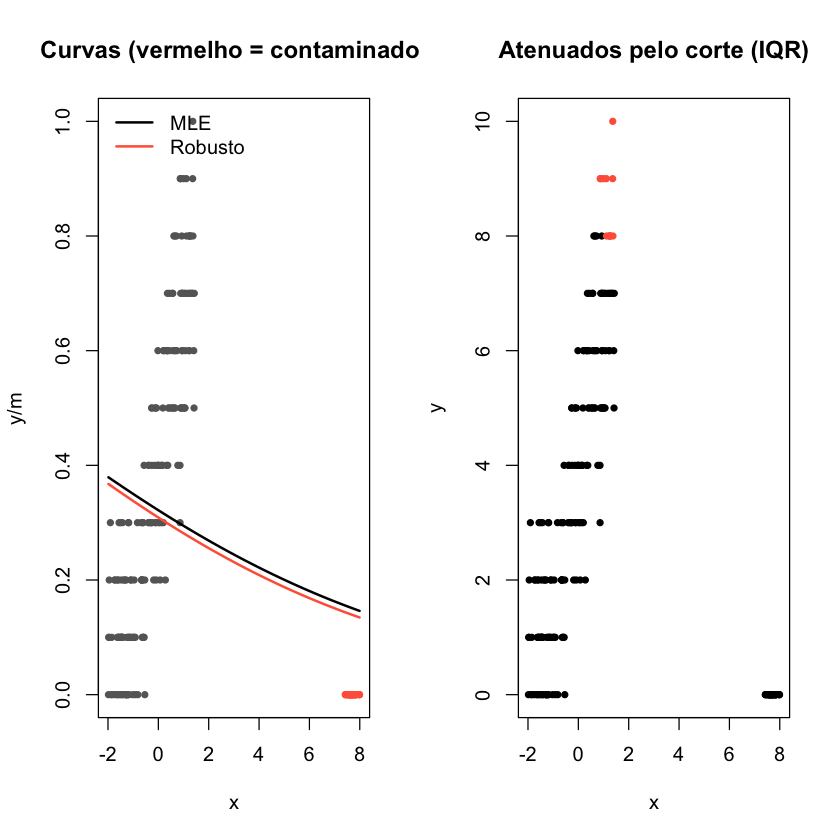

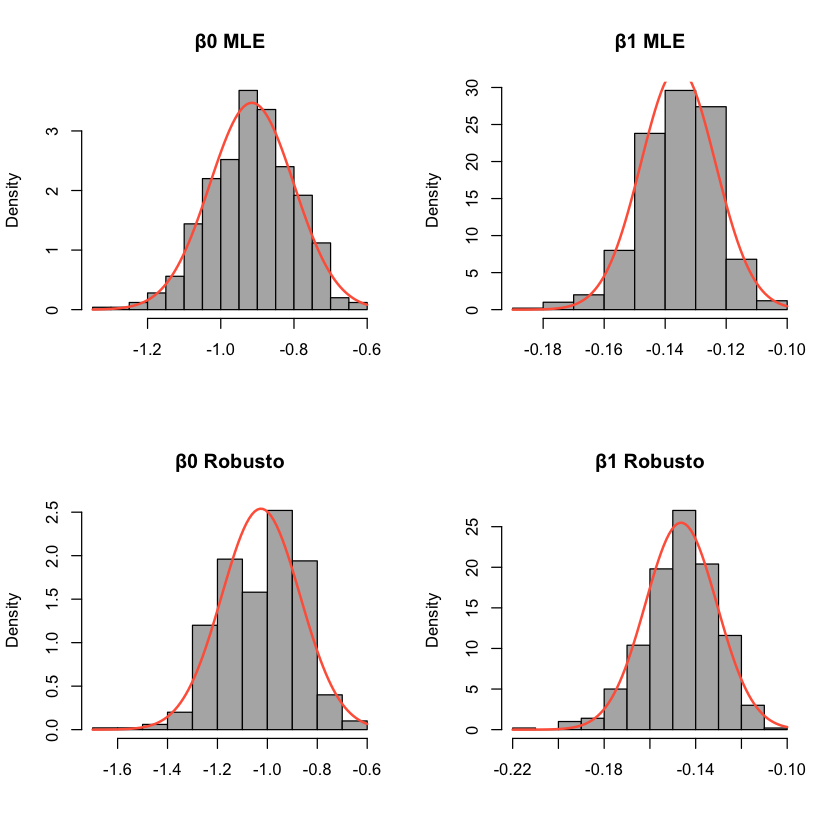

In [6]:
## ==========================================================
##  Binomial robusto (IQR + exp(-(|r|-c)_+)) com contaminação
##  adversária p/ mostrar viés no MLE e robustez no proposto
## ==========================================================

expit = function(eta) 1/(1+exp(-eta))
set.seed(2025)

## --------------------------
## Exemplo único (adversário)
## --------------------------
n = 220
m = rep(10, n)
x = runif(n, -2, 2)

theta = c(-0.5, 1.2)
mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação adversária: pegue os MAIORES x (alta alavancagem),
## force y=0 (contrariando beta1>0) e empurre x pra direita
contam = 0.18
delta_x = 6
k = round(contam*n)
idx = order(x, decreasing=TRUE)[1:k]
y[idx] = 0
x[idx] = x[idx] + delta_x

## MLE
fit0 = glm(cbind(y, m-y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## Robusto
p = 1.4
L = function(th){
  eta = th[1] + th[2]*x
  mu  = expit(eta)
  r   = y - m*mu
  c   = p * IQR(r)
  w   = exp(-pmax(0, abs(r) - c))
  cbind( w*(y - m*mu),
         w*x*(y - m*mu) )
}
LL = function(th){ u = colSums(L(th)); sum(u^2) }

B = function(th){ U = L(th); t(U) %*% U / n }
V = function(th){
  eps = 1e-6; U0 = colSums(L(th)); J = matrix(NA_real_,2,2)
  for(j in 1:2){ thj = th; thj[j] = thj[j]+eps; Uj = colSums(L(thj)); J[,j]=(Uj-U0)/eps }
  solve(J) %*% B(th) %*% t(solve(J))
}

fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

## plots do exemplo
par(mfrow=c(1,2))
plot(y/m ~ x, pch=20, col=ifelse(1:n %in% idx, "tomato", "grey40"),
     main="Curvas (vermelho = contaminado)")
xs = seq(min(x), max(x), length=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto"), col=c("black","tomato"), lwd=2, bty="n")

r.now = y - m*expit(theta.hat1[1] + theta.hat1[2]*x)
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Atenuados pelo corte (IQR)", pch=20)

theta      ;  theta.hat0   ;  theta.hat1

## --------------------------
##  Monte Carlo adversário
## --------------------------
mc_binom_advers = function(R=400, n=220, contam=0.18, delta_x=6, p=1.4){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  theta = c(-0.5, 1.2)
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)

    k = round(contam*n)
    idx = order(x, decreasing=TRUE)[1:k]
    y[idx] = 0
    x[idx] = x[idx] + delta_x

    b_mle = coef(glm(cbind(y, m-y) ~ x, family=binomial()))

    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      w   = exp(-pmax(0, abs(r) - c))
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }
    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par, silent=TRUE)
    if(inherits(b_rob,"try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(77)
res = mc_binom_advers(R=500, n=220, contam=0.18, delta_x=6, p=1.4)

summ = function(v, tru) c(mean=mean(v,na.rm=TRUE),
                         bias=mean(v-tru,na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2,na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], -0.5),
  "MLE beta1" = summ(res[,2],  1.2),
  "ROB beta0" = summ(res[,3], -0.5),
  "ROB beta1" = summ(res[,4],  1.2)
)
round(TAB, 3)

par(mfrow=c(2,2))
hist(res[,1], prob=TRUE, col="grey70", main="β0 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,1],na.rm=TRUE), sd=sd(res[,1],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,2], prob=TRUE, col="grey70", main="β1 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,2],na.rm=TRUE), sd=sd(res[,2],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,3], prob=TRUE, col="grey70", main="β0 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,3],na.rm=TRUE), sd=sd(res[,3],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)
hist(res[,4], prob=TRUE, col="grey70", main="β1 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,4],na.rm=TRUE), sd=sd(res[,4],na.rm=TRUE)), add=TRUE, col="tomato", lwd=2)

[1] -0.5  1.2

(Intercept)           x 
 -0.5275917   0.9264467

(Intercept)           x 
 -0.4466449   1.2942475

,mean,bias,rmse
MLE beta0,-0.557,-0.057,0.081
MLE beta1,0.845,-0.355,0.368
ROB beta0,-0.482,0.018,0.061
ROB beta1,1.279,0.079,0.099


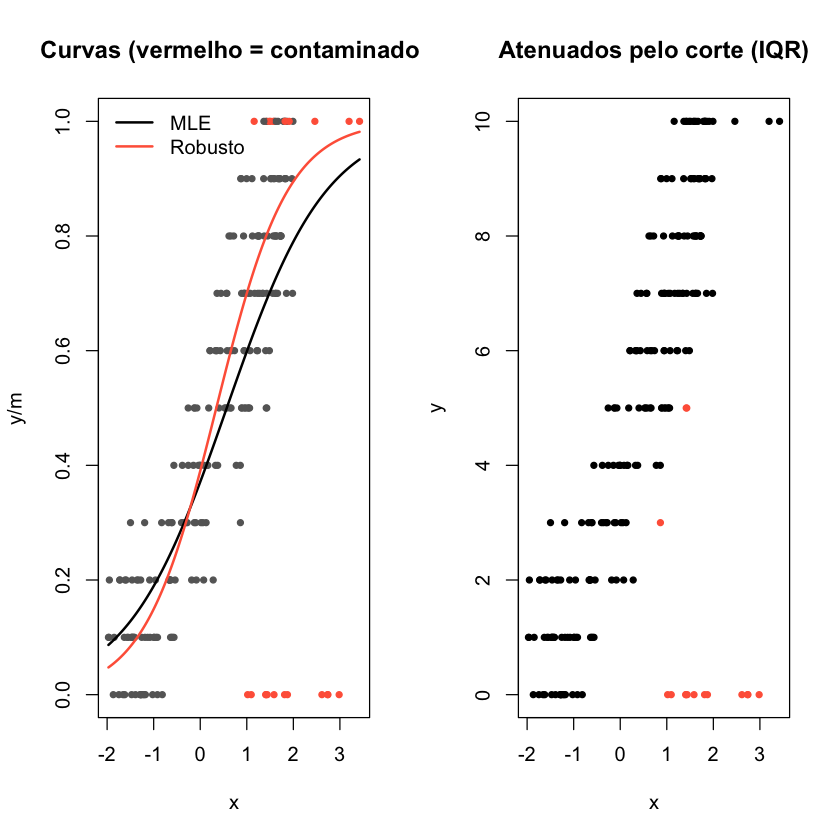

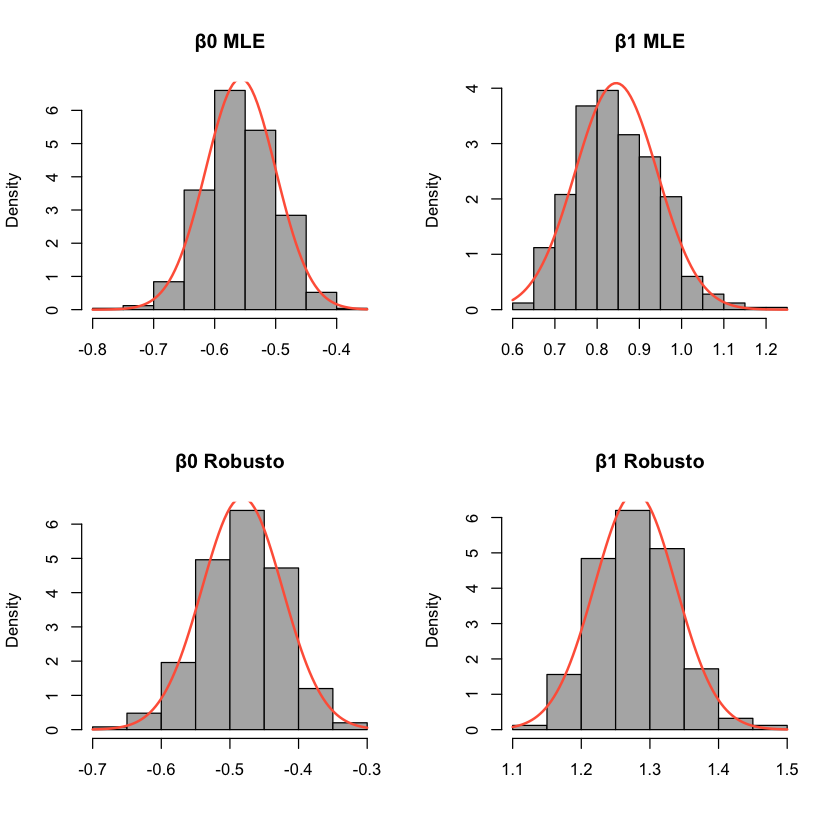

In [9]:
## ==========================================================
##  Binomial robusto (IQR + exp(-(|r|-c)_+)) com contaminação
##  tipo aula (pontos baixos empurrados e rotulados 0/m)
## ==========================================================

expit = function(eta) 1/(1+exp(-eta))
set.seed(2025)

## --------------------------
## Exemplo único (aula-style)
## --------------------------
n = 220
m = rep(10, n)
x = runif(n, -2, 2)
theta = c(-0.5, 1.2)
mu = expit(theta[1] + theta[2]*x)
y  = rbinom(n, size=m, prob=mu)

## contaminação mista (a da aula)
aux = sample(which(x < 0.5), round(0.10*n))
x[aux] = x[aux] + 3
y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])

## MLE
fit0 = glm(cbind(y, m-y) ~ x, family=binomial())
theta.hat0 = coef(fit0)

## Robusto
p = 1.5
L = function(th){
  eta = th[1] + th[2]*x
  mu  = expit(eta)
  r   = y - m*mu
  c   = p * IQR(r)
  w   = exp(-pmax(0, abs(r) - c))
  cbind( w*(y - m*mu),
         w*x*(y - m*mu) )
}
LL = function(th){ u = colSums(L(th)); sum(u^2) }

B = function(th){ U = L(th); t(U) %*% U / n }
V = function(th){
  eps = 1e-6; U0 = colSums(L(th)); J = matrix(NA_real_,2,2)
  for(j in 1:2){ thj = th; thj[j] = thj[j]+eps; Uj = colSums(L(thj)); J[,j]=(Uj-U0)/eps }
  solve(J) %*% B(th) %*% t(solve(J))
}

fit1 = optim(LL, par=theta.hat0, control=list(reltol=1e-12))
theta.hat1 = fit1$par
V.hat = V(theta.hat1)

## --------------------------
## Plots do exemplo
## --------------------------
par(mfrow=c(1,2))
plot(y/m ~ x, pch=20, col=ifelse(1:n %in% aux, "tomato", "grey40"),
     main="Curvas (vermelho = contaminado)")
xs = seq(min(x), max(x), length=200)
lines(xs, expit(theta.hat0[1] + theta.hat0[2]*xs), lwd=2, col="black")
lines(xs, expit(theta.hat1[1] + theta.hat1[2]*xs), lwd=2, col="tomato")
legend("topleft", c("MLE","Robusto"), col=c("black","tomato"), lwd=2, bty="n")

r.now = y - m*expit(theta.hat1[1] + theta.hat1[2]*x)
cut.now = p * IQR(r.now)
plot(y ~ x, col=ifelse(abs(r.now) > cut.now, "tomato", "black"),
     main="Atenuados pelo corte (IQR)", pch=20)

theta; theta.hat0; theta.hat1

## --------------------------
##  Monte Carlo (aula-style)
## --------------------------
mc_binom_aula = function(R=500, n=220, contam=0.10, p=1.5){
  out = matrix(NA_real_, R, 4)
  colnames(out) = c("b0_mle","b1_mle","b0_rob","b1_rob")
  theta = c(-0.5, 1.2)
  m = rep(10, n)
  for(t in 1:R){
    x = runif(n, -2, 2)
    mu = expit(theta[1] + theta[2]*x)
    y  = rbinom(n, size=m, prob=mu)
    aux = sample(which(x < 0.5), round(contam*n))
    x[aux] = x[aux] + 3
    y[aux] = ifelse(runif(length(aux)) < 0.5, 0, m[aux])
    b_mle = coef(glm(cbind(y, m-y) ~ x, family=binomial()))
    L = function(th){
      eta = th[1] + th[2]*x
      mu  = expit(eta)
      r   = y - m*mu
      c   = p * IQR(r)
      w   = exp(-pmax(0, abs(r) - c))
      cbind( w*(y - m*mu),
             w*x*(y - m*mu) )
    }
    LL = function(th){ u = colSums(L(th)); sum(u^2) }
    b_rob = try(optim(LL, par=b_mle, control=list(reltol=1e-12))$par,
                silent=TRUE)
    if(inherits(b_rob, "try-error")) next
    out[t,] = c(b_mle[1], b_mle[2], b_rob[1], b_rob[2])
  }
  out
}

set.seed(77)
res = mc_binom_aula(R=500, n=220, contam=0.10, p=1.5)

summ = function(v, tru) c(mean=mean(v,na.rm=TRUE),
                         bias=mean(v-tru,na.rm=TRUE),
                         rmse=sqrt(mean((v-tru)^2,na.rm=TRUE)))
TAB = rbind(
  "MLE beta0" = summ(res[,1], -0.5),
  "MLE beta1" = summ(res[,2],  1.2),
  "ROB beta0" = summ(res[,3], -0.5),
  "ROB beta1" = summ(res[,4],  1.2)
)
round(TAB, 3)

## --------------------------
##  PLOTS (com curva normal)
## --------------------------
par(mfrow=c(2,2))
hist(res[,1], prob=TRUE, col="grey70", main="β0 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,1],na.rm=TRUE), sd=sd(res[,1],na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)
hist(res[,2], prob=TRUE, col="grey70", main="β1 MLE", xlab="")
curve(dnorm(x, mean=mean(res[,2],na.rm=TRUE), sd=sd(res[,2],na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)
hist(res[,3], prob=TRUE, col="grey70", main="β0 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,3],na.rm=TRUE), sd=sd(res[,3],na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)
hist(res[,4], prob=TRUE, col="grey70", main="β1 Robusto", xlab="")
curve(dnorm(x, mean=mean(res[,4],na.rm=TRUE), sd=sd(res[,4],na.rm=TRUE)),
      add=TRUE, col="tomato", lwd=2)